In [128]:

##### TEST FILE CALIBRAZIONE PRESSURE INDEPENDENT MULTI YELD #################
import openseespy.opensees as ops
import numpy as np
import matplotlib.pyplot as plt

In [129]:
%%capture cap

##### VARIANTE CON SHAKE ALLA BASE##########

ops.wipe()

### VARIABILE DEFORMAZIONE
#postamento = 0.01

ndm = 3
ndf = 4

ops.model('basic','-ndm', ndm, '-ndf', ndf)


#### INPUT NODI
ops.node(1, 0.0, 0.0, 0.0)
ops.node(2, 0.0, 1.0, 0.0)
ops.node(3, 1.0, 1.0, 0.0)
ops.node(4, 1.0, 0.0, 0.0)
ops.node(5, 0.0, 0.0, 1.0)
ops.node(6, 0.0, 1.0, 1.0)
ops.node(7, 1.0, 1.0, 1.0)
ops.node(8, 1.0, 0.0, 1.0)

####GID - MODEL EXPORT
mesh=open("test.msh","w")
element=open("elementsInfo.dat","w")
nodes=open("nodesInfo.dat","w")
mesh.write("MESH dimension 3 ElemType Hexahedra Nnode 8\n") 
mesh.write("Coordinates\n")
mesh.write("#node_number   coord_x   coord_y   coord_z\n")
d=[[1,[0.0,0.0,0.0]],[2,[0.0,1.0,0.0]],[3,[1.0,1.0,0.0]],[4,[1.0,0.0,0.0]],[5,[0.0,0.0,1.0]],[6,[0.0,1.0,1.0]],[7,[1.0,1.0,1.0]],[8,[1.0,0.0,1.0]]]
for i in d:
      xCoord =  i[1][0]
      yCoord =  i[1][1]
      zCoord =  i[1][2]
      mesh.write(f"{i[0]} {xCoord}    {yCoord}    {zCoord}\n")
      nodes.write(f"{i[0]} {xCoord}    {yCoord}    {zCoord}\n")
mesh.write("end coordinates\n")
mesh.write("Elements\n")
mesh.write("# element   nodo1  nodo2   nodo3   nodo4   nodo5   nodo6   nodo7   nodo8\n")
elem = 1
nodo1 = d[0][0]
nodo2 = d[1][0]
nodo3 = d[2][0]
nodo4 = d[3][0]
nodo5 = d[4][0]
nodo6 = d[5][0]
nodo7 = d[6][0]
nodo8 = d[7][0]
nodes_l = [nodo1,nodo2,nodo3,nodo4,nodo5,nodo6,nodo7,nodo8]
mesh.write(f"{elem} {nodo1} {nodo2} {nodo3} {nodo4} {nodo5} {nodo6} {nodo7} {nodo8} \n")
element.write(f"{elem} {nodo1} {nodo2} {nodo3} {nodo4} {nodo5} {nodo6} {nodo7} {nodo8}\n")
mesh.write("end elements")

element.close()
mesh.close()
nodes.close()

#cohesion1 = 30.0
peakShearStrain1 = 0.10
E1 = 90000.0
poisson = 0.30 # NON DRENATO
G1 = E1/(2.0*(1+poisson))
print(f'G1:{G1}')
B1 = E1/(3.0*(1-2.0*poisson))
solid1 = 10 # tag
fi = 35
p_ref = 80.0
PTAng = 34
n_surf = 20
pDepCoh = 0.5
contrac =0.1   # 0.05
dilat1 = 5.0 # 0.8
dilat2 = 5.0 # 5.0
liq1 = 0.0
liq2 = 0.0
liq3 = 0.0



#### FLUIDO
Bfluid = 2.2e6
fluid1 = 1 #tag
fmass = 1.0
perm = 1.0

#### PARAMETRI ANALISI

rhoS = 2.0 #densità saturo
rhoF = 1.0 #massa fluida

#### MOLTIPLICATORI
densityMult = 1 
spostamento = 0.005 
massProportionalDamping = 0 
InitialStiffnessProportionalDamping = 0.001 

#### ACC DI GRAVITA'
bUnitWeightX = 0
bUnitWeightY = 0
bUnitWeightZ = -9.81*(rhoS-rhoF)

### DIMENSIONE E GDL
ops.model('basic','-ndm', ndm, '-ndf', ndf)

#### DICHIARAZIONE MATERIALI E INTERAZIONE FLUIDO

#nDMaterial PressureDependMultiYield $tag $nd $rho $refShearModul $refBulkModul $frictionAng $peakShearStra $refPress $pressDependCoe 
#$PTAng $contrac $dilat1 $dilat2 $liquefac1 $liquefac2 $liquefac3 
#<$noYieldSurf=20 <$r1 $Gs1 …> $e=0.6 $cs1=0.9 $cs2=0.02 $cs3=0.7 $pa=101
#<$c=0.3>>
ops.nDMaterial('PressureDependMultiYield', solid1, ndm,rhoS,G1,B1,fi,peakShearStrain1,p_ref,pDepCoh,PTAng,contrac,dilat1,dilat2,liq1,liq2,liq3,n_surf)
#Attenzione: dare tutti i valori altrimenti ci sono in input valori di default interi ma richiesti in cifra doppia
#per analisi non drenate ed elementi non up
#ops.nDMaterial('FluidSolidPorous',fluid1,ndm,solid1,Bfluid)


#element brickUP $eleTag $Node1 $Node2 $Node3 $Node4 $Node5 $Node6 
#$Node7 $Node8 $matTag $bulk $fmass $PermX $PermY $PermZ <$bX=0 
#$bY=0 $bZ=0>
ops.element('brickUP',1,1,2,3,4,5,6,7,8,solid1,B1,fmass,perm,perm,perm,bUnitWeightX,bUnitWeightY,bUnitWeightZ)

ops.updateMaterialStage('-material', solid1, '-stage', 0)
#ops.updateMaterialStage('-material', fluid1, '-stage', 0)


#### VINCOLI - BASE INCASTRATA
ops.fix(1,1,1,1,0)
ops.fix(2,1,1,1,0)
ops.fix(3,1,1,1,0)
ops.fix(4,1,1,1,0)
ops.fix(5,1,1,0,0)
ops.fix(6,1,1,0,0)
ops.fix(7,1,1,0,0)
ops.fix(8,1,1,0,0)



### GRAVITY LOADING
ops.system('ProfileSPD')
ops.test('NormDispIncr',1.0e-9,50,2)
ops.constraints('Penalty',1.0e18,1.0e18)
ops.integrator('Newmark',0.5,0.25)
ops.algorithm('Newton')
ops.numberer('RCM')
ops.analysis('Transient')
ops.analyze(1,1)

#### FASE PLASTICA

#ops.updateMaterialStage("-material",fluid1,"-stage",1)
ops.updateMaterialStage("-material",solid1,"-stage",1)


###### AZIONE VERTICALE
#load_f = 0.000001
#ops.timeSeries('Constant',11,'-factor',load_f)
#ops.pattern('Plain',2,11,'-factor',1)
#ops.load(5,0,0,-1,0)
#ops.load(6,0,0,-1,0)
#ops.load(7,0,0,-1,0)
#ops.load(8,0,0,-1,0)

ops.analyze(100,0.01)


print('fine fase di inizializzazione')

ops.wipeAnalysis()


#### EQUAL DOF

ops.remove('sp',1,1)
ops.remove('sp',2,1)
ops.remove('sp',3,1)
ops.remove('sp',4,1)

ops.remove('sp',1,2)
ops.remove('sp',2,2)
ops.remove('sp',3,2)
ops.remove('sp',4,2)

ops.remove('sp',1,3)
ops.remove('sp',2,3)
ops.remove('sp',3,3)
ops.remove('sp',4,3)

ops.remove('sp',5,1)
ops.remove('sp',6,1)
ops.remove('sp',7,1)
ops.remove('sp',8,1)

ops.remove('sp',5,2)
ops.remove('sp',6,2)
ops.remove('sp',7,2)
ops.remove('sp',8,2)

ops.remove('sp',5,3)
ops.remove('sp',6,3)
ops.remove('sp',7,3)
ops.remove('sp',8,3)

ops.fix(1,0,1,1,0)
ops.fix(2,0,1,1,0)
ops.fix(3,0,1,1,0)
ops.fix(4,0,1,1,0)

ops.fix(5,1,1,0,0)
ops.fix(6,1,1,0,0)
ops.fix(7,1,1,0,0)
ops.fix(8,1,1,0,0)

ops.equalDOF(5,8 ,1)
ops.equalDOF(5,7 ,1)
ops.equalDOF(5,6 ,1)

ops.equalDOF(5,8 ,3)
ops.equalDOF(5,7 ,3)
ops.equalDOF(5,6 ,3)

ops.equalDOF(1,2 ,1)
ops.equalDOF(3,4 ,1)


##### CHANGE PARAM PERMEAB
permh = 0.001
permv = 0.001

eleTags = []
getParamTags = []
for i in ops.getParamTags():
    getParamTags.append(i)
LT = len(getParamTags)
if getParamTags == []:
        tag = 1
else:
    tag = int(getParamTags[LT - 1]) + 1

for i in ops.getEleTags():
    eleTags.append(int(i))

LT2 = len(eleTags)
for j in range(0, LT2 - 1):
    i = eleTags[j]
    ops.parameter(int(tag), 'element', i, 'hPerm')
    ops.parameter(int(tag + 1), 'element', i, 'vPerm')
    #ops.parameter(int(tag + 2), 'element', i, 'permZ')
    ops.updateParameter(int(tag), hPerm)
    ops.updateParameter(int(tag + 1), vPerm)
    #ops.updateParameter(int(tag + 2), permZ)

### ATTENZIONE NON CAMBIARE IL NOME DEL FILE ALTRIMENTI SALTANO I DIAGRAMMI ###############################
ops.setTime(0.0)

durata = 5
periodo = 10
dt = 0.001
numSteps = int(durata/dt)

ops.recorder("Node",'-file', 'base_disp1.out', '-time', '-node', 1, '-dof', 1, 'disp')
ops.recorder("Node",'-file', 'Top_disp8.out', '-time', '-node', 5, '-dof', 1, 'disp')
ops.recorder("Node",'-file', 'Top_accel8.out', '-time', '-node', 1, '-dof', 1, 'accel')
ops.recorder("Node",'-file', 'press1.out', '-time', '-node', 1, '-dof', 4, 'vel')

#### GID DISPLAY
ops.recorder("Node",'-file', 'displacement.out', '-time', '-node', 1,2,3,4,5,6,7,8, '-dof', 1,2,3, 'disp')
ops.recorder("Node",'-file', 'acceleration.out', '-time', '-node', 1,2,3,4,5,6,7,8, '-dof', 1,2,3, 'accel')
ops.recorder("Node",'-file', 'porePressure.out', '-time', '-node', 1,2,3,4,5,6,7,8, '-dof', 4, 'vel')

ops.recorder('Element','-ele',1,'-time','-file','stress1.out','-dT',dt,'material',1,'stress')
ops.recorder('Element','-ele',1,'-time','-file','stress2.out','-dT',dt,'material',2,'stress')
ops.recorder('Element','-ele',1,'-time','-file','stress3.out','-dT',dt,'material',3,'stress')
ops.recorder('Element','-ele',1,'-time','-file','stress4.out','-dT',dt,'material',4,'stress')
ops.recorder('Element','-ele',1,'-time','-file','stress5.out','-dT',dt,'material',5,'stress')
ops.recorder('Element','-ele',1,'-time','-file','stress6.out','-dT',dt,'material',6,'stress')
ops.recorder('Element','-ele',1,'-time','-file','stress7.out','-dT',dt,'material',7,'stress')
ops.recorder('Element','-ele',1,'-time','-file','stress8.out','-dT',dt,'material',8,'stress')

ops.recorder('Element','-ele',1,'-time','-file','strain1.out','-dT',dt,'material',1,'strain')
ops.recorder('Element','-ele',1,'-time','-file','strain2.out','-dT',dt,'material',2,'strain')
ops.recorder('Element','-ele',1,'-time','-file','strain3.out','-dT',dt,'material',3,'strain')
ops.recorder('Element','-ele',1,'-time','-file','strain4.out','-dT',dt,'material',4,'strain')
ops.recorder('Element','-ele',1,'-time','-file','strain5.out','-dT',dt,'material',5,'strain')
ops.recorder('Element','-ele',1,'-time','-file','strain6.out','-dT',dt,'material',6,'strain')
ops.recorder('Element','-ele',1,'-time','-file','strain7.out','-dT',dt,'material',7,'strain')
ops.recorder('Element','-ele',1,'-time','-file','strain8.out','-dT',dt,'material',8,'strain')




#ops.recorder('Element','-ele',1,'-time','-file','stress1.out','-dT',dt,'material',1,'stress')
#ops.recorder('Element','-ele',1,'-time','-file','strain1.out','-dT',dt,'material',1,'strain')

#ops.recorder('Element','-ele',1,'-time','-file','press1.out','-dT',dt,'material',1,'pressure')
ops.recorder('Element','-ele',1,'-time','-file','backbone.out','-dT',dt,'material',1,'backbone',150)



# multiple-support excitation: displacement input at individual nodes
#pattern MultipleSupport $IDloadTag  {
#	foreach SupportNode $iSupportNode GMdirection $iGMdirection GMSineDispAmpl $iGMSineDispAmpl TPeriodSine $iTPeriodSine DurationSine $iDurationSine {
#		set IDgmSeries [expr $IDgmSeries +1]
#		set DispSeries "Sine 0. $DurationSine $TPeriodSine -factor $GMSineDispAmpl"
#		groundMotion $IDgmSeries Plain -disp  $DispSeries  
#	     	imposedMotion $SupportNode  $GMdirection $IDgmSeries
#	};	# end foreach	
#};	# end pattern

gammaN = 0.6
ops.timeSeries('Trig', 10, 0.0, durata, periodo, '-factor', spostamento)
ops.pattern('MultipleSupport',1)

#groundMotion(gmTag, ’Plain’, ’-disp’, dispSeriesTag, ’-vel’, velSeriesTag, ’-accel’, accelSeriesTag, ’-int’,
#tsInt=’Trapezoidal’, ’-fact’, factor=1.0)
ops.groundMotion(20,'Plain','-disp',10)

#imposedMotion(nodeTag, dof, gmTag)
ops.imposedMotion(1,1,20)
ops.imposedMotion(2,1,20)
ops.imposedMotion(3,1,20)
ops.imposedMotion(4,1,20)


ops.rayleigh(massProportionalDamping,0.0,InitialStiffnessProportionalDamping,0.0)
#ops.integrator('Newmark',gammaN,((gammaN+0.5)**2)/4) da esercizio
ops.integrator('Newmark',0.5,0.25)
ops.constraints('Penalty',1e18,1e18)
ops.test('NormDispIncr',1.0e-8,50,0)
ops.algorithm('Newton')
ops.system('ProfileSPD')
ops.numberer('RCM')

#ops.analysis('VariableTransient')
#ops.analyze(numSteps,dt,dt/64,dt,15)

ops.analysis('Transient')
ops.analyze(numSteps, dt)
#ops.analyze(1,1)


ops.wipe()
print('fine fase di taglio')

In [130]:
out = cap.show()
with open('output_stderr.txt', 'w') as file:
    file.write(cap.stderr)
file.close

G1:34615.38461538462
fine fase di inizializzazione
fine fase di taglio


CTestNormDispIncr::test() - iteration: 2 current Norm: 2.41614e-10 (max: 1e-09, Norm deltaR: 3.45494e-15)
CTestNormDispIncr::test() - iteration: 6 current Norm: 9.3019e-10 (max: 1e-09, Norm deltaR: 6.61774e-09)
CTestNormDispIncr::test() - iteration: 7 current Norm: 8.21765e-11 (max: 1e-09, Norm deltaR: 5.73253e-10)
CTestNormDispIncr::test() - iteration: 2 current Norm: 2.3046e-14 (max: 1e-09, Norm deltaR: 3.86772e-15)
CTestNormDispIncr::test() - iteration: 2 current Norm: 5.67075e-15 (max: 1e-09, Norm deltaR: 2.35458e-15)
CTestNormDispIncr::test() - iteration: 2 current Norm: 4.93645e-15 (max: 1e-09, Norm deltaR: 1.78034e-15)
CTestNormDispIncr::test() - iteration: 2 current Norm: 1.65776e-14 (max: 1e-09, Norm deltaR: 4.96584e-15)
CTestNormDispIncr::test() - iteration: 2 current Norm: 3.32981e-15 (max: 1e-09, Norm deltaR: 5.6118e-15)
CTestNormDispIncr::test() - iteration: 2 current Norm: 1.49272e-14 (max: 1e-09, Norm deltaR: 3.55688e-15)
CTestNormDispIncr::test() - iteration: 2 current 

<function TextIOWrapper.close()>

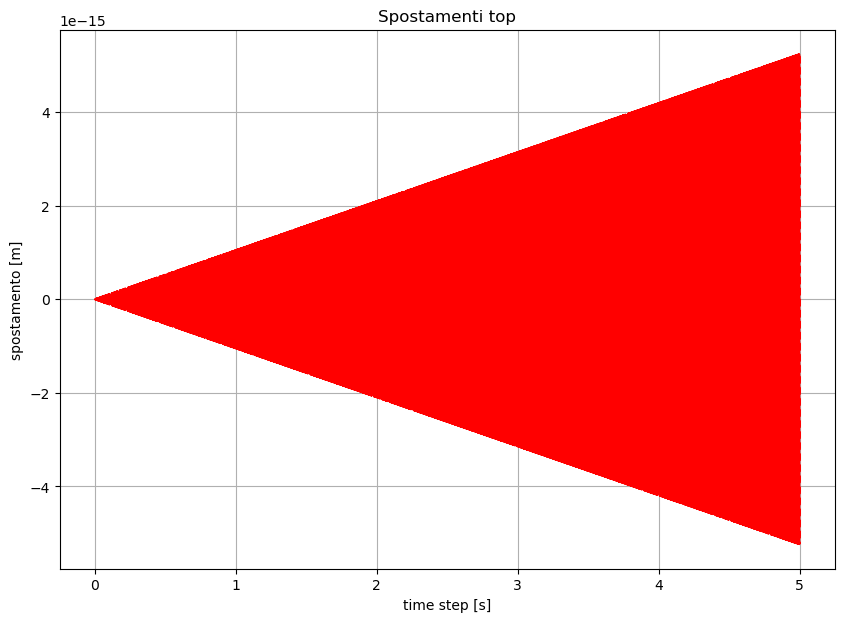

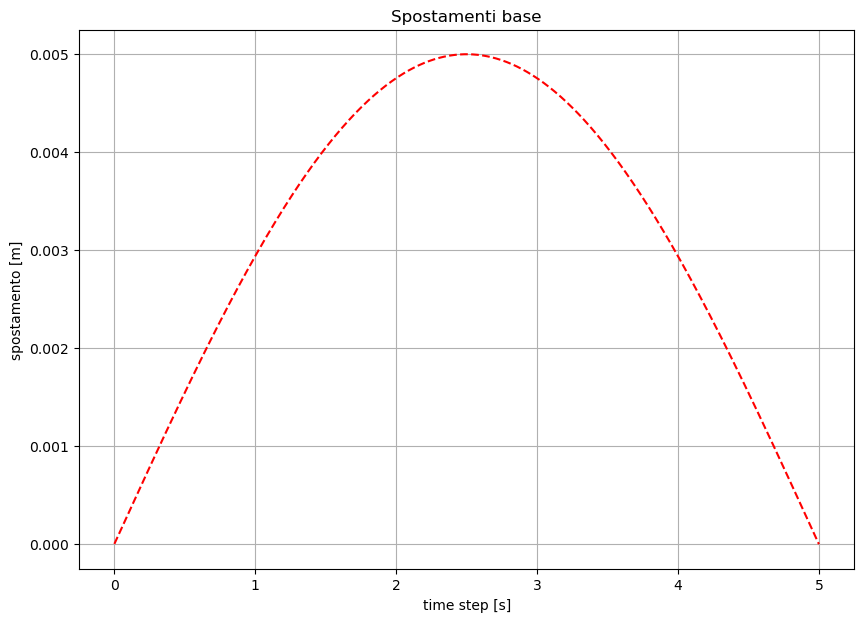

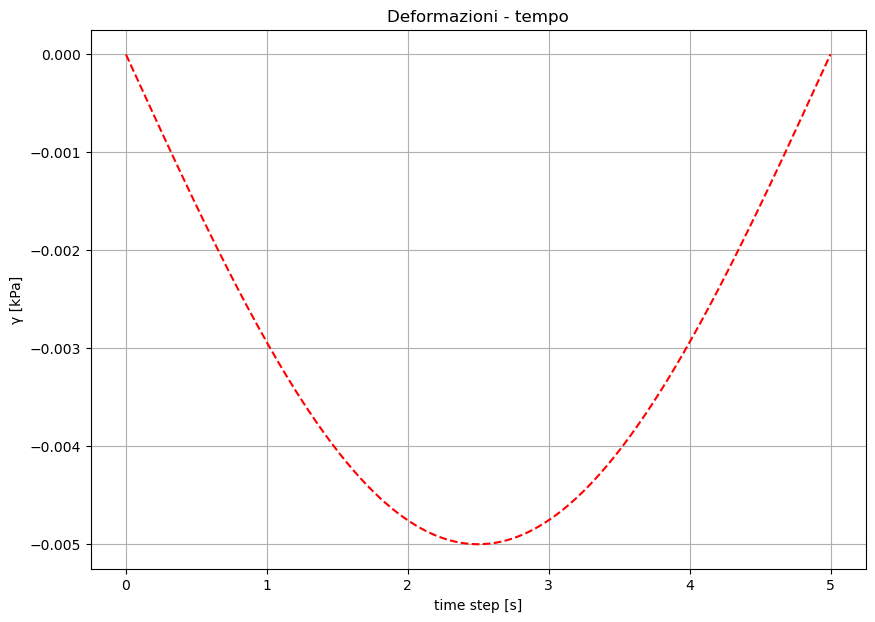

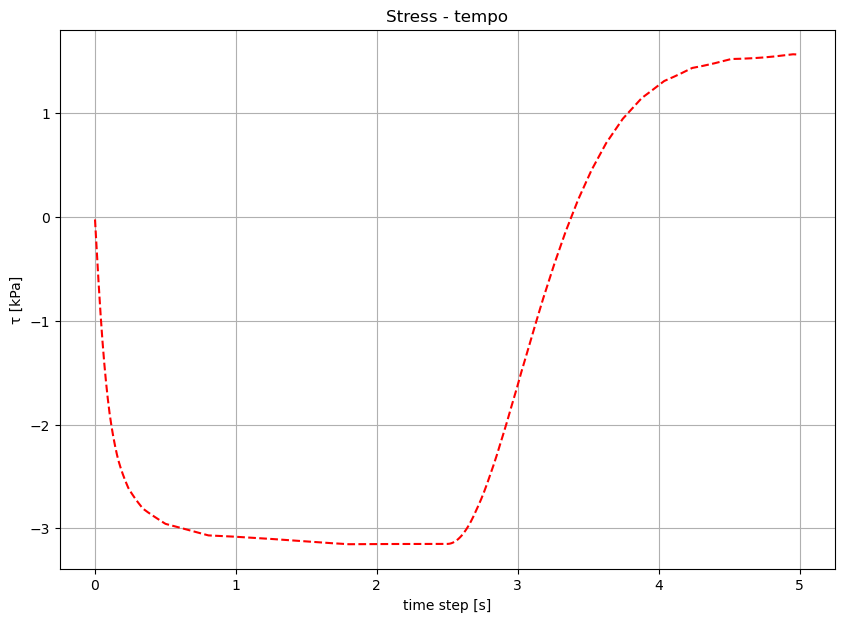

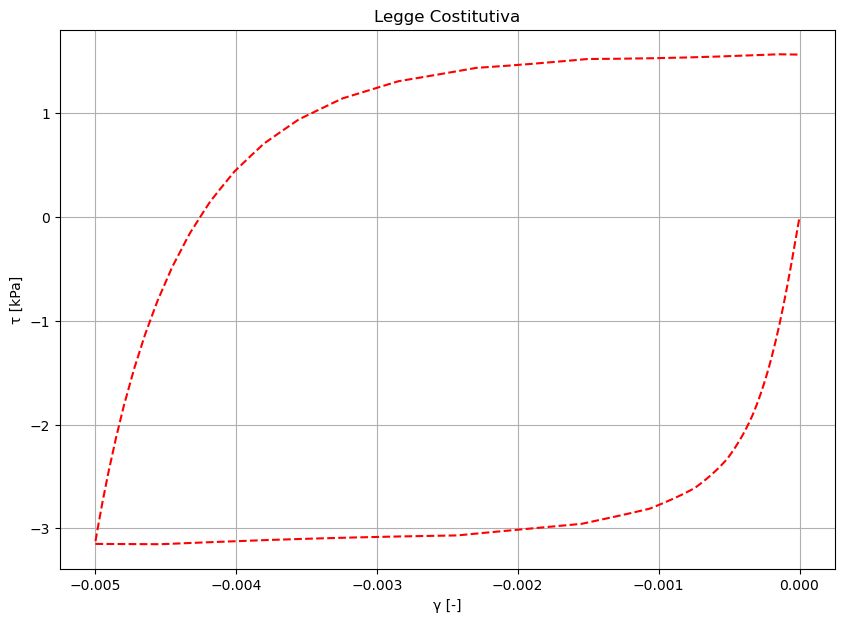

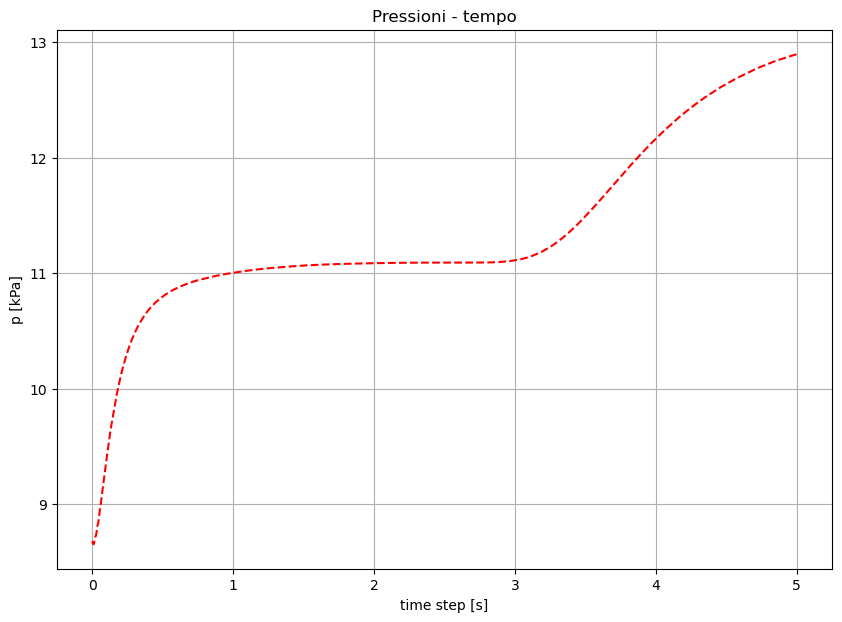

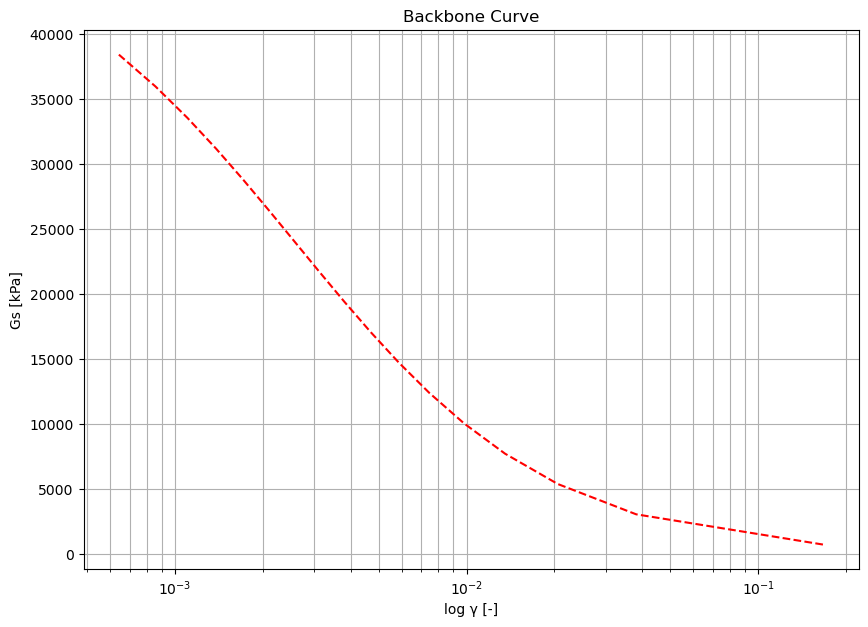

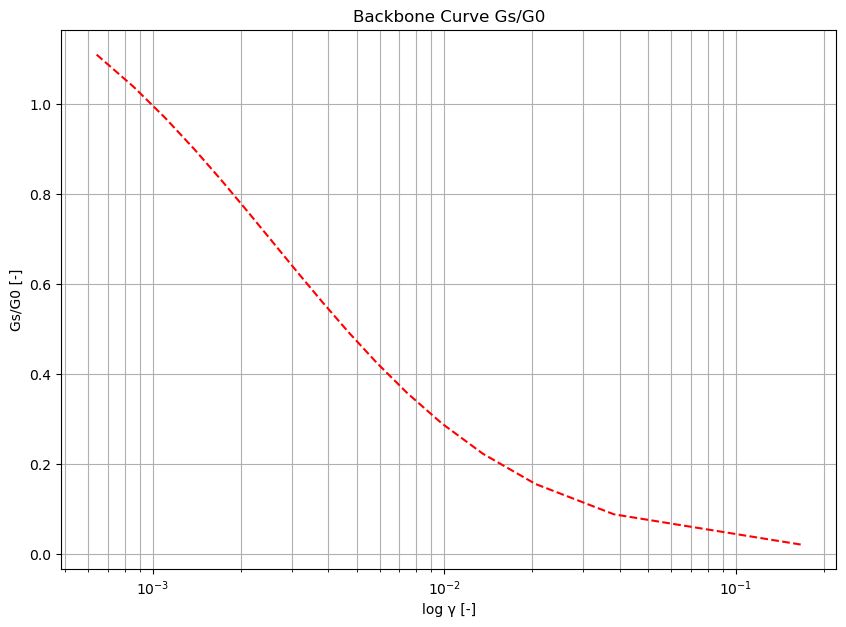

In [131]:
### PLOT SPOSTAMENTI PER STEP (tempo statico fittizzio)
disp=open('Top_disp8.out','r')
lines = disp.readlines()
l = len(lines)

disp_down=open('base_disp1.out','r')
lines_down = disp_down.readlines()
l_down = len(lines_down)

acc=open('Top_accel8.out','r')
lines2 = acc.readlines()
l2 = len(lines2)

stress=open('stress1.out','r')
lines3 = stress.readlines()
l3 = len(lines3)

strain=open('strain1.out','r')
lines4= strain.readlines()
l4 = len(lines4)

press=open('press1.out','r')
lines5= press.readlines()
l5 = len(lines5)

spost = [float(y[0]) for y in [x[1].split('\n') for x in [lines[x].split(' ') for x in range(l)] ]]
spost_down = [float(y[0]) for y in [x[1].split('\n') for x in [lines_down[x].split(' ') for x in range(l_down)] ]]

accel = [float(y[0]) for y in [x[1].split('\n') for x in [lines2[x].split(' ') for x in range(l2)] ]]
steps1 = [float(y[0]) for y in [lines2[x].split(' ') for x in range(l) ]]   

tau = [float(z[0]) for z in [y[6].split('\n') for y in [lines3[x].split(' ') for x in range(l3)]]]
strain = [float(z[0]) for z in [y[6].split('\n') for y in [lines4[x].split(' ') for x in range(l4)]]]
pressure = [float(y[0]) for y in [x[1].split('\n') for x in [lines5[x].split(' ') for x in range(l5)] ]]
pressure_t = [float(y[0]) for y in [x[0].split('\n') for x in [lines5[x].split(' ') for x in range(l5)] ]]
steps2 = [float(y[0]) for y in [lines3[x].split(' ') for x in range(l3) ]]   


### BACKBONE CURVE ###
backb = open('backbone.out')
readb = backb.readlines()
lb = len(readb)
# #gamma = [float(x) for x in [readb[x].split(' ') for x in range(l)][0][9:]]
list_1 = [float(i) for i in [readb[x].split(' ') for x in range(lb)][0][9:]]
gamma = [float(i) for i in [readb[x].split(' ') for x in range(lb)][0][9:]][::2] #indici 0 2 4 6
Gs = [float(i) for i in [readb[x].split(' ') for x in range(lb)][0][10:]][::2]

#### PLOT #####

fig, ax = plt.subplots(figsize=(10,7))
fig_d,dx = plt.subplots(figsize=(10,7))
# fig1,ax1=plt.subplots()
fig1,ax2=plt.subplots(figsize=(10,7))
fig2,ax3=plt.subplots(figsize=(10,7))
fig3,ax4=plt.subplots(figsize=(10,7))
fig4,ax5=plt.subplots(figsize=(10,7))


ax.set_title('Spostamenti top')
ax.set_ylabel('spostamento [m]')
ax.set_xlabel('time step [s]')
ax.grid(True)
ax.plot(steps1, spost,'r--')

dx.set_title('Spostamenti base')
dx.set_ylabel('spostamento [m]')
dx.set_xlabel('time step [s]')
dx.grid(True)
dx.plot(steps1, spost_down,'r--')


ax2.set_title('Deformazioni - tempo')
ax2.set_ylabel(chr(947)+' '+'[kPa]')
ax2.set_xlabel('time step [s]')
ax2.plot(steps2,strain,'r--')
ax2.grid(True)

ax3.set_title('Stress - tempo')
ax3.set_ylabel(chr(964)+' '+'[kPa]')
ax3.set_xlabel('time step [s]')
ax3.plot(steps2,tau,'r--')
ax3.grid(True)

#### NON CI SONO ACCELERAZIONI ANALISI STATICA ######
#ax4.plot(steps,accel)
ax4.set_title('Legge Costitutiva')
ax4.set_ylabel(chr(964)+' '+'[kPa]')
ax4.set_xlabel(chr(947)+' '+'[-]')
ax4.plot(strain,tau,'r--')
ax4.grid(True)
#ax.set_xscale('log')
#ax.ylim(-2, 2)
#plt.ylim(-0.001,0.001)

ax5.set_title('Pressioni - tempo')
ax5.set_ylabel('p'+' '+'[kPa]')
ax5.set_xlabel('time step [s]')
ax5.plot(pressure_t,pressure,'r--')
ax5.grid(True)

#### plot backbone
fig, bb = plt.subplots(figsize=(10,7))
bb.set_title('Backbone Curve')
bb.set_ylabel('Gs [kPa]')
bb.set_xlabel('log'+' '+chr(947)+' '+'[-]')
bb.plot(gamma, Gs,'r--')
bb.grid(True)
bb.grid(which='minor')
bb.set_xscale('log')


Gs_G0 = list(map(lambda num: num/G1,Gs))
fig, bb1 = plt.subplots(figsize=(10,7))
bb1.set_title('Backbone Curve Gs/G0')
bb1.set_ylabel('Gs/G0 [-]')
bb1.set_xlabel('log'+' '+chr(947)+' '+'[-]')
bb1.plot(gamma, Gs_G0,'r--')
bb1.grid(True)
bb1.grid(which='minor')
bb1.set_xscale('log')

# Mostra il grafico

plt.show()

